<h1>Collaborative filtering</h1>
<p>
Collaborative filtering is a method of making automatic predictions about the interests of a user by collecting preferences from many user. There are many libraries(LightFM, Implicit, Surprise) that help us to create optimized models for collaborative filtering. I tried all three but LightFM seems to be the best for this simple project. 
</p>
<p>
    The design of recommendation algorithms is influenced by the system used for tracking
ratings. There are two types of ratings when we speak about recommender systems: implicit and explicit. Explicit rating are based on rating that are set by an user. They are typically interval-based, where a discrete set of ordered numbers are used to quantify like or dislike of the user. Example -  on the end of a movie user can rate the movie on 5-point rating scale. On the other hand, implicit rating are gathered by a system that user interact with(clicking on en email, buying a product). This kind of rating is mostly binary. Because our data contains only implicit rating - (product view, adding a product to cart, buying a product) I decided to use LightFM because of its support for implicit rating.
</p>

<p>
    Collaborative filtering works very well if a user preferences are known. If a user is unknow for the system or he provided very few ratings, collaborative recommender system can not find relevant items for the user. This is know as cold start problem. Cold start problem are typicaly solved by using different types of recommendation systems. They are based on a fact that similar users tend to like similar items and similar items are visited by similar users. So when a new user visits a webpage, similar users are found. Then we can find what similar users likeand  recommend same products to the new users. Similarity can be computed from user features such a gender, age, location. Our dataset does not contain user features but provides item features. The item features can be used to create model for calculating similarity between items. This model can recommend similar items to the new user that had visited new items. This model is constructed in second notebook. In this notebook I describe how collaborative recommender system was build.
   </p>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
events = pd.read_csv("dataset_events.csv")
print("nuber of events:" ,events.shape[0])
events.head()

nuber of events: 653419


,customer_id,product_id,type,timestamp
0,1,19685,view_product,1527812004
1,1,19685,view_product,1527812041
2,1,19685,add_to_cart,1527812046
3,1,19685,view_product,1527812048
4,1,19685,view_product,1527812050


In [3]:
print(events.info())
print()
print("Number of unique customers:", len(np.unique(events.customer_id.values)))
print("Number of unique products:", len(np.unique(events.product_id.values)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653419 entries, 0 to 653418
Data columns (total 4 columns):
customer_id    653419 non-null int64
product_id     653419 non-null int64
type           653419 non-null object
timestamp      653419 non-null int64
dtypes: int64(3), object(1)
memory usage: 19.9+ MB
None

Number of unique customers: 83762
Number of unique products: 28369


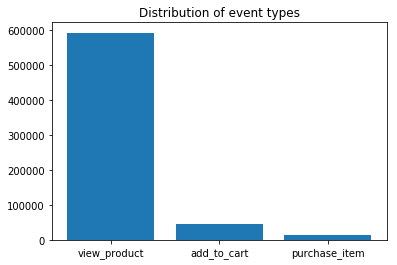

In [4]:
plt.bar(events.type.value_counts().keys(), events.type.value_counts().values)
plt.title("Distribution of event types")
plt.show()

We can see that implicit rating - feedback about user preferences is provided by three events types. Most of the events are "view_product". We can use only one event type for building a model which would not use knowleage of whole dataset. Or we can build three different models for every event type and then combine their recommendations. The best would be to use single model that uses all the event types. The following cells contains a code that groups different event types by customer and product id. The result is smaller dataframes with additional columns that contain information about how many times an user "created" an event on specific product.

counting and grouping by "View_product"

In [205]:
only_views = events[events.type=="view_product"].drop(columns=['type', 'timestamp'])
grouped_views_by_customer_id = only_views.groupby(['customer_id', 'product_id']).product_id.agg('count').to_frame('n_views').reset_index()
grouped_views_by_customer_id.head()

,customer_id,product_id,n_views
0,1,19685,4
1,2,7953,1
2,3,5156,1
3,3,5157,1
4,4,4633,1


counting and grouping by "add_to_cart"

In [208]:
only_cart = events[events.type=="add_to_cart"].drop(columns=['type', 'timestamp'])
grouped_cart_by_customer_id = only_cart.groupby(['customer_id', 'product_id']).product_id.agg('count').to_frame('n_cart').reset_index()
grouped_cart_by_customer_id.head()

,customer_id,product_id,n_cart
0,1,19685,1
1,5,8589,1
2,7,3151,1
3,7,13690,1
4,7,14463,1


counting and grouping by "purchase_item"

In [209]:
only_purchases = events[events.type=="purchase_item"].drop(columns=['type', 'timestamp'])
grouped_purchases_by_customer_id = only_purchases.groupby(['customer_id', 'product_id']).product_id.agg('count').to_frame('n_purchases').reset_index()
grouped_purchases_by_customer_id.head()

,customer_id,product_id,n_purchases
0,10,6963,1
1,22,4209,1
2,22,27912,1
3,43,24413,1
4,44,3814,1


Mergeing dataframes

In [213]:
customer_product = events[['customer_id', 'product_id']].drop_duplicates().reset_index(drop=True)
event_counts = pd.merge(customer_product, grouped_views_by_customer_id,  how='left', left_on=['customer_id','product_id'], right_on = ['customer_id','product_id'])
event_counts['n_views'].fillna(0, inplace=True)
event_counts = pd.merge(event_counts, grouped_cart_by_customer_id,  how='left', left_on=['customer_id','product_id'], right_on = ['customer_id','product_id'])
event_counts['n_cart'].fillna(0, inplace=True)
event_counts = pd.merge(event_counts, grouped_purchases_by_customer_id,  how='left', left_on=['customer_id','product_id'], right_on = ['customer_id','product_id'])
event_counts['n_purchases'].fillna(0, inplace=True)
event_counts.head()

,customer_id,product_id,n_views,n_cart,n_purchases
0,1,19685,4.0,1.0,0.0
1,2,7953,1.0,0.0,0.0
2,3,5156,1.0,0.0,0.0
3,3,5157,1.0,0.0,0.0
4,4,21122,4.0,0.0,0.0


Checking if aggregation was correct

In [9]:
print(event_counts['n_views'].sum(), events[events.type=="view_product"].shape)
print(event_counts['n_cart'].sum(), events[events.type=="add_to_cart"].shape)
print(event_counts['n_purchases'].sum(), events[events.type=="purchase_item"].shape)

event_counts.shape, events[['product_id', 'customer_id']].drop_duplicates().shape


592299.0 (592299, 4)
46121.0 (46121, 4)
14999.0 (14999, 4)


((357930, 5), (357930, 2))

Now our data are prepared to create valid input for LightFM models. The library provides function to create sparse matrix of interacions directly from a dataframe. The dataframe should reperesent a list of tuples (customer_id, product_id) or triple (customer_id, product_id, weight). The weight is used to quantify like of the user. We can use fact that when a customer adds a product to the cart he likes the product more likely than just visiting it and when he purchases the product several times he likes the product most likely. In following cell I created new column "rating" and set its value according to these rules:

In [48]:
event_counts['rating'] = 0 #default value

idxs = event_counts[event_counts.n_views == 1].index #set the weight to 1 when customer visited the product once
event_counts.loc[idxs, 'rating'] = 1 

idxs = event_counts[event_counts.n_views > 1].index #set the weight to 2 when customer visited the product several times
event_counts.loc[idxs, 'rating'] = 2

idxs = event_counts[event_counts.n_cart == 1].index #set the weight to 3 when customer added the product to cart
event_counts.loc[idxs, 'rating'] = 3

idxs = event_counts[event_counts.n_cart > 1].index #set the weight to 4 when customer added the product to cart several times
event_counts.loc[idxs, 'rating'] = 4triple 

idxs = event_counts[event_counts.n_purchases == 1].index #set the weight to 5 when customer bought the product
event_counts.loc[idxs, 'rating'] = 5

idxs = event_counts[event_counts.n_purchases > 1].index #set the weight to 6 when customer bought the product several times
event_counts.loc[idxs, 'rating'] = 6
event_counts.head()

,customer_id,product_id,n_views,n_cart,n_purchases,rating
0,1,19685,4.0,1.0,0.0,3
1,2,7953,1.0,0.0,0.0,1
2,3,5156,1.0,0.0,0.0,1
3,3,5157,1.0,0.0,0.0,1
4,4,21122,4.0,0.0,0.0,2


Dropping unnecessary columns.


In [49]:
ratings = event_counts.drop(columns=['n_views','n_cart','n_purchases']).reset_index(drop=True).values
ratings

array([[    1, 19685,     3],
       [    2,  7953,     1],
       [    3,  5156,     1],
       ...,
       [86015,  8706,     1],
       [86015, 13357,     2],
       [86015, 13356,     2]], dtype=int64)

Building interaction matrix with help of Dataset class

In [50]:

from lightfm.data import Dataset

dataset = Dataset()
dataset.fit(
    users = set(ratings[:, 0]),
    items = set(ratings[:, 1])
)
_, interactions = dataset.build_interactions(ratings)
interactions

<83762x28369 sparse matrix of type '<class 'numpy.float32'>'
	with 357930 stored elements in COOrdinate format>

According to several resources, for collaborative filtering to work, it is needed to have interaction matrix with sparsity at most 99.5%. Setting the sparsity under this value can be done by removing customers and product with only few views. This method helped to create a model with higher precision but it also means that we need to create a different model for filtered customers. This model is build in second notebook.

Following cell shows us that raw interacion matrix has 99.98% which is very high.

In [51]:
def get_sparsity(M):
    matrix_size = M.shape[0]*M.shape[1] 
    num_events = len(M.nonzero()[0])
    sparsity = 100*(1 - (num_events/matrix_size))
    return sparsity

get_sparsity(interactions), interactions.shape, type(interactions), np.max(interactions)

(99.98493715404697, (83762, 28369), scipy.sparse.coo.coo_matrix, 6.0)

Decreasing sparsity of the interacion matrix is done by removing product that have under 50 views and customers that have less then 7 views. Filtering is done by following cell. I tried different values but these lead to best precision of the model while not removing too many interactions.

In [52]:
min_product_events_count = 50
grouped_events_by_product_id = events.groupby(['product_id']).customer_id.agg('count').to_frame('n_events').reset_index()
products_with_more_than_n_events = grouped_events_by_product_id[grouped_events_by_product_id.n_events>min_product_events_count]
products_with_more_than_n_events = np.array(products_with_more_than_n_events.product_id)

min_customer_events_count = 7
grouped_events_by_customer_id = events.groupby(['customer_id']).product_id.agg('count').to_frame('n_events').reset_index()
customers_with_more_than_n_events = grouped_events_by_customer_id[grouped_events_by_customer_id.n_events>min_customer_events_count]
customers_with_more_than_n_events = np.array(customers_with_more_than_n_events.customer_id)

print(customers_with_more_than_n_events.shape, products_with_more_than_n_events.shape)

filtered_event_counts = event_counts.loc[event_counts.product_id.isin(products_with_more_than_n_events)]
filtered_event_counts = filtered_event_counts.loc[event_counts.customer_id.isin(customers_with_more_than_n_events)]

final_df =  filtered_event_counts.drop(columns=['n_views','n_cart','n_purchases']).reset_index(drop=True)
ratings = final_df.values
ratings.shape

(18782,) (2315,)


(134444, 3)

In [53]:
len(set(filtered_event_counts.customer_id)), len(set(filtered_event_counts.product_id)), ratings.shape

(17826, 2315, (134444, 3))

Building the final interaction matrix

In [58]:
dataset = Dataset()
dataset.fit(
    users = set(ratings[:, 0]),
    items = set(ratings[:, 1])
)
_, interactions = dataset.build_interactions(ratings)

get_sparsity(interactions), interactions.shape, type(interactions), np.max(interactions)

(99.67421091671132, (17826, 2315), scipy.sparse.coo.coo_matrix, 6.0)

<h2>Collaborative recommender system</h2>

In [59]:
from lightfm.cross_validation import random_train_test_split
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

LightFM model uses its own internal product and customer ids. Dataset.mapping() returns dictionaries which translate real product/customer ids to internal ids

In [78]:
mappings = dataset.mapping()
user_mapping, item_mapping = mappings[0], mappings[2]
len(item_mapping), len(user_mapping)

(2315, 17826)

To see how our model is doing the interaction matrix is "split" to two train and test matrices. 

In [79]:
train, test= random_train_test_split(interactions, test_percentage=0.20, random_state=np.random.RandomState(seed=42))

train.shape, test.shape, get_sparsity(train), get_sparsity(test)

((17826, 2315), (17826, 2315), 99.73936921801557, 99.93484169869575)

Setting a baseline model is also good way how to check performance of a model. I created two baseline models. The first model simply recommends random items. The easiest way how to create a random matrix with relevant sparsity is to randomly shuffle default interaction matrix. 

In [80]:
from scipy.sparse import csr_matrix

rnd = np.array(interactions.todense()).copy()
np.random.shuffle(rnd)
random = csr_matrix(rnd)
random.shape, get_sparsity(random)

((17826, 2315), 99.67421091671132)

Second baseline model is created from popular products. The model simply recommends 5 most popular products to every customer. Finding the most popular products is done in third notenook. Here I just imported them. An empty interaction matrix is created and then every row of the matrix is filled with 5 most viewed products, 5 most added-to-cart products and 5 most purchased products. This creates an interaction matrix with similar sparsity.

In [98]:
sorted_popular_items_by_purchase = np.load('sorted_popular_items_by_purchase.npy')
sorted_popular_items_by_cart_add = np.load('sorted_popular_items_by_cart_add.npy')
sorted_popular_items_by_views = np.load('sorted_popular_items_by_views.npy')
n_popular = 5
popular = np.zeros(train.shape)
for id in sorted_popular_items_by_views[:n_popular]:
    if id in item_mapping:
        idx = item_mapping[id]
        popular[:, idx] = 1 #rating for a view
        
for id in sorted_popular_items_by_cart_add[:n_popular]:
    if id in item_mapping:
        idx = item_mapping[id]
        popular[:, idx] = 3 #rating for adding to cart

for id in sorted_popular_items_by_purchase[:n_popular]:
    if id in item_mapping:
        idx = item_mapping[id]
        popular[:, idx] = 5 #rating for a purchase
        
popular = csr_matrix(popular)
get_sparsity(popular)

99.61123110151188

<p>
LightFM is easy to use. It provieds single model with different loss function. The documentation says that warp loss function is appropriate for implicit ratings. I tried several different hyperparameters but as project assignment says, it is not the goal of the project to maximize precision of models.
</p>
<p>
    We can see that model that makes random recommendations is worst - only 0.6 AUC. Model that recommends the most popular items is much better - more than 0.83 AUC. The best model is LightFM model with 0.91 AUC on test set which is not bad.
</p>

In [99]:
model = LightFM(loss='warp', no_components=40)

model.fit_partial(train, epochs=15, verbose=True)

d = {
    "random": random,
    "popular": popular,
    "train": train,
    "test": test,
}
for key in d:
    precision = precision_at_k(model, d[key], k=10, num_threads=4).mean()
    recall = recall_at_k(model, d[key], k=10, num_threads=4).mean()
    f1 = (2*precision*recall)/(precision+recall) 
    print("{:10} precision: {:5.4f} recall: {:5.4f} f1: {:4.4f}".format(key, precision, recall, f1))
for key in d:
    auc = auc_score(model, d[key], num_threads=4).mean()
    print("{:10} AUC: {:5.4f}".format(key, auc))


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
random     precision: 0.0150 recall: 0.0201 f1: 0.0172
popular    precision: 0.0977 recall: 0.1085 f1: 0.1028
train      precision: 0.3567 recall: 0.7501 f1: 0.4835
test       precision: 0.0592 recall: 0.3197 f1: 0.0999
random     AUC: 0.6028
popular    AUC: 0.8390
train      AUC: 0.9964
test       AUC: 0.9184


Making recommendations

In [191]:
user_id = 423
user_idx = user_mapping[user_id]
n_recommended_items = 20

product_idxs = np.array(list(item_mapping.values()))
product_ids = np.array(list(item_mapping.keys()))

scores = model.predict([user_idx], list(item_mapping.values()))

sorted_idxs = np.argsort(-scores)[:n_recommended_items]

print("Recommended items:\n", product_ids[sorted_idxs])
print("Recommended item scores:\n", scores[sorted_idxs])

recommended_item_ids = product_ids[sorted_idxs]

Recommended items:
 [ 3133 20734 21413   331 21417 12053 21415 21416 21414 24439 22031 21411
 21412   437 21122 22127 10289  3146 21410  9804]
Recommended item scores:
 [1.83076382 1.82239783 1.67513633 1.62306786 1.39467371 1.31348443
 1.28727615 1.28337586 1.26176095 1.24249721 1.23888063 1.18871486
 1.18356371 1.14689004 1.12942445 1.12779057 1.07092488 1.05691826
 1.05348837 1.02433622]


Another way how to check if the model works is to use model for finding most similar products to given product. The model is created in second notebook. We can use the fact that products that are recommended for a user should be more similar among each other than randomly selected products. Following cell contains a function that calculate average similarity among products provided in list. The similarities are gathered and averaged.

In [192]:
import requests

def get_average_similairty_among_recommened_items(recommended_item_ids):
    similarities = []
    l1 = recommended_item_ids.copy()
    np.random.shuffle(recommended_item_ids) #randomly shuffle the list
    l2 = recommended_item_ids.copy() 
    pairs = list(zip(l1, l2)) #making list of pairs
    for p in pairs:
        response = requests.get('http://127.0.0.1:5000/similarity/'+str(p[0])+'/'+str(p[1])) 
        similarity = response.json()
        similarities.append(similarity)
        
    return np.mean(similarities)

We can see that average similarity among recommended products of most user is much higher than average similarity among randomly picked products.

In [199]:
print("Average similarity among recommended items", get_average_similairty_among_recommened_items(recommended_item_ids))

np.random.shuffle(product_ids) #randoly shuffle all product ids
random_ids = product_ids[:n_recommended_items] #pick first n random products

print("Average similarity among random products", get_average_similairty_among_recommened_items(random_ids))

Average similarity among recommended items 0.597437227491562
Average similarity among random products 0.40770431755463593


We can pick several random users, make recommendations for them and average average similarity among recommended products.

In [214]:
avg_recommended_similarities = []
avg_random_similarities = []

n_recommended_items = 20
n_users = 50

for i, user_id in enumerate(np.random.permutation(list(user_mapping.keys()))[:n_users]):
    print(str(i+1)+". user")
    user_idx = user_mapping[user_id]

    product_idxs = np.array(list(item_mapping.values()))
    product_ids = np.array(list(item_mapping.keys()))

    scores = model.predict([user_idx], list(item_mapping.values()))

    sorted_idxs = np.argsort(-scores)[:n_recommended_items]

    recommended_item_ids = product_ids[sorted_idxs]
    
    avg_recommended_similarities.append(get_average_similairty_among_recommened_items(recommended_item_ids))
    print("Average similarity among recommended items", avg_recommended_similarities[-1])
    
    np.random.shuffle(product_ids)
    random_ids = product_ids[:n_recommended_items]

    avg_random_similarities.append(get_average_similairty_among_recommened_items(random_ids))
    print("Average similarity among random products", avg_random_similarities[-1])


1. user
Average similarity among recommended items 0.861
Average similarity among random products 0.4750208078398244
2. user
Average similarity among recommended items 0.6170807168950778
Average similarity among random products 0.5364807358684254
3. user
Average similarity among recommended items 0.6438654655244872
Average similarity among random products 0.48168602998526266
4. user
Average similarity among recommended items 0.6091776695296638
Average similarity among random products 0.6308522403646941
5. user
Average similarity among recommended items 0.6296564615223301
Average similarity among random products 0.46703247926875846
6. user
Average similarity among recommended items 0.48850000000000005
Average similarity among random products 0.48525426480542944
7. user
Average similarity among recommended items 0.5994692906356733
Average similarity among random products 0.44823334547203386
8. user
Average similarity among recommended items 0.86
Average similarity among random products 0

Average similarity among recommended products is much higher than similarity among randomly selected products. This leads me to conclusion that both models work and output reasonable data.

In [204]:
print("Average similarity among recommended products", np.mean(avg_recommended_similarities))
print("Average similarity among random products ", np.mean(avg_random_similarities))

Average similarity among recommended products 0.6874085727086827
Average similarity among random products  0.49682225586372825


<p>
This noteboks shows how collaborative recommender system is build. Most of the code was used in flask application where I created 3 recommender systems(SimilarityRecommender, PopRecommender, LightFmRecommender). The system decides to use one of them for making recommendations based on how many products had a user seen. If the user is new and has no interaction with the system only most popular products are recommended. If the user has only few interactions with products, similar products are recommended. If the user has more interactions, this model is used. This logic is coded in Controller class in get_recommendations method:
</p>

In [ ]:
class Controller:

    def __init__(self):
        self.similarityRecommender = SimilarityRecommender()
        self.popRecommender = PopRecommender()
        self.lightFmRecommender = LightFmRecommender()

    def train(self):
        self.similarityRecommender.train()
        self.popRecommender.train()
        self.lightFmRecommender.train()

    def get_n_most_similar_products(self, product_id, n):
        return self.similarityRecommender.get_n_most_similar_products(product_id, n)

    def get_similarity_between_products(self, product_id1, product_id2):
        return self.similarityRecommender.get_similarity_between_products(product_id1, product_id2)

    def get_recommendations(self, customer_id, n):
        if self.lightFmRecommender.can_recommend(customer_id
                                                 
            return self.lightFmRecommender.recommend(customer_id, n)
                                                 
        if self.similarityRecommender.can_recommend(customer_id):
                                                 
            return self.similarityRecommender.recommend(customer_id, n)
        else:
            return self.popRecommender.recommend(n)

The controller class composes three recommender models. All the models are inherited from the same abstract class RecommenderABC. Names of the methods are self explanatory.

In [216]:
from abc import ABC, abstractmethod

class RecommenderABC(ABC):
    
    @abstractmethod
    def train(self):
        pass
    
    @abstractmethod
    def can_recommend(self):
        pass
    
    @abstractmethod
    def recommend(self):
        pass

The controller is called from routes.py which contains following endpoints:
<ul>
    <li>http://127.0.0.1:5000/recommender/train - trains all three models</li>
    <li>http://127.0.0.1:5000/similarity/&lt;int:product_id&gt; - returns n most similar products to a product_id</li>
    <li>http://127.0.0.1:5000/similarity/&lt;int:product_id1&gt;/&lt;int:product_id2&gt; - returns similarity between two products</li>
    <li>http://127.0.0.1:5000/recommender/&lt;int:customer_id&gt; - returns recommened items for customer_id</li>
</ul>